In [64]:
from binpack.models import Result
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [81]:
results = Result.objects.filter(n_tiles=20)

In [82]:
results.values('score')

<QuerySet [{'score': 5.0}, {'score': 5.0}, {'score': 5.0}, {'score': 2.0}, {'score': 4.0}, {'score': 4.0}, {'score': 3.0}, {'score': 2.0}, {'score': 6.0}, {'score': 3.0}, {'score': 4.0}, {'score': 6.0}, {'score': 3.0}, {'score': 6.0}, {'score': 7.0}, {'score': 2.0}, {'score': 10.0}, {'score': 6.0}, {'score': 7.0}, {'score': 4.0}, '...(remaining elements truncated)...']>

In [83]:
avg_depth_scores = results.filter(strategy='avg_depth').values('score')
max_depth_scores = results.filter(strategy='max_depth').values('score')
scores = results.values('score', 'strategy')

In [84]:
scores_df = pd.DataFrame.from_records(scores)
avg_depth_df = pd.DataFrame.from_records(avg_depth_scores)
def score_to_int(df):
    df['score'] = df['score'].astype('int')
    return df

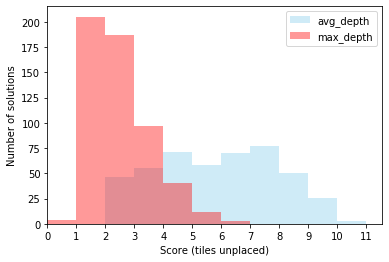

In [85]:
# scores_df
plt.figure('Results distribution')
bins = np.arange(0, 12)
sns.distplot(score_to_int(pd.DataFrame.from_records(avg_depth_scores)), kde=False, color='skyblue', label='avg_depth', bins=bins)
ax = sns.distplot(score_to_int(pd.DataFrame.from_records(max_depth_scores)), kde=False, color='red', label='max_depth', bins=bins)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.xlim(left=0)
plt.ylabel('Number of solutions')
plt.xlabel('Score (tiles unplaced)')
plt.legend()
plt.show()

In [93]:
# find total scores by annotation
from django.db.models import Count
results.values('score').annotate(total_for_score=Count('score'))

<QuerySet [{'score': 10.0, 'total_for_score': 2}, {'score': 0.0, 'total_for_score': 4}, {'score': 4.0, 'total_for_score': 111}, {'score': 5.0, 'total_for_score': 70}, {'score': 2.0, 'total_for_score': 233}, {'score': 7.0, 'total_for_score': 77}, {'score': 11.0, 'total_for_score': 1}, {'score': 9.0, 'total_for_score': 26}, {'score': 3.0, 'total_for_score': 153}, {'score': 1.0, 'total_for_score': 205}, {'score': 6.0, 'total_for_score': 73}, {'score': 8.0, 'total_for_score': 50}]>

In [94]:
results.count()

1005